EDA descripción.
 * Descrición de dataset
     - Cuantas columnas tiene
     - el tipo de las columnas
     - cuantos null tiene cada columna
 * Descripción de la columna objetivo
     - Cantidad de etiquetas
     - distribución de los etiquetados

### Imports

In [1]:
import findspark
import pandas as pd
from optimus import Optimus
from pyspark.sql import SparkSession


/opt/conda/lib/python3.7/site-packages/socks.py:58: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable


#### Start Spark

In [2]:
findspark.init()
spark = SparkSession.builder.appName('meetUp_optimus').getOrCreate()

#### Start Optimus 

In [3]:
op = Optimus()

#### Read csv

In [4]:
df_items_meli = op.read.csv(
    '../data/train.csv',
    header=True
)

#### Dataset

¿Cuantas columnas tiene este dataset?

In [5]:
columns_df = df_items_meli.columns
print(f'Este Dataset tiene {len(columns_df)} columnas')
print(f'Son: {columns_df}')

Este Dataset tiene 4 columnas
Son: ['title', 'label_quality', 'language', 'category']


##### Tipos de las columnas

In [6]:
df_items_meli.printSchema()

root
 |-- title: string (nullable = true)
 |-- label_quality: string (nullable = true)
 |-- language: string (nullable = true)
 |-- category: string (nullable = true)



In [7]:
nulls_in_col = df_items_meli.cols.count_na(columns_df)

Including 'nan' as Null in processing 'title'
Including 'nan' as Null in processing 'label_quality'
Including 'nan' as Null in processing 'language'
Including 'nan' as Null in processing 'category'


In [8]:
pd.Series(
    nulls_in_col,
    name='Nulls'
)

title             1
label_quality    25
language         25
category         25
Name: Nulls, dtype: int64

Los nulls se tienen que eliminar

#### Columna target

In [9]:
df_items_meli.select('category').limit(100).distinct().table(10)

category 1 (string) nullable
ELECTRIC_PRESSURE_WASHERS
SOUND_CARDS
WASHING_MACHINES
VEHICLE_BRAKE_DISCS
FALSE_EYELASHES
IRRIGATION_SPRINKLERS
RACQUETS
CAMERA_TRIPODS
AUTOMOTIVE_AIR_FILTERS
LUNCHBOXES


In [39]:
df_items_meli.groupby('category').count().sort('count', ascending=False).table(10)

category 1 (string) nullable,count 2 (bigint) not nullable
PANTS,35973
COFFEE_MAKERS,35104
BABY_CAR_SEATS,34163
MUSICAL_KEYBOARDS,33222
MATTRESSES,32967
PUREBRED_DOGS,32928
RANGES,32645
REFRIGERATORS,32635
MOTORCYCLE_JACKETS,32615
HAIR_CLIPPERS,32372


In [10]:
groupby_category_items = df_items_meli.groupby('category').count().sort('count', ascending=False).cache()

In [12]:
groupby_category_items.show()

+------------------+-----+
|          category|count|
+------------------+-----+
|             PANTS|35973|
|     COFFEE_MAKERS|35104|
|    BABY_CAR_SEATS|34163|
| MUSICAL_KEYBOARDS|33222|
|        MATTRESSES|32967|
|     PUREBRED_DOGS|32928|
|            RANGES|32645|
|     REFRIGERATORS|32635|
|MOTORCYCLE_JACKETS|32615|
|     HAIR_CLIPPERS|32372|
|            SHORTS|31685|
|         SUITCASES|31580|
|      MEMORY_CARDS|31564|
|             WINES|31399|
|     ROLLER_SKATES|31371|
|    BABY_STROLLERS|31353|
|   SEWING_MACHINES|31129|
|   ELECTRIC_DRILLS|30820|
|     KITCHEN_SINKS|30635|
|       WALL_CLOCKS|30600|
+------------------+-----+
only showing top 20 rows



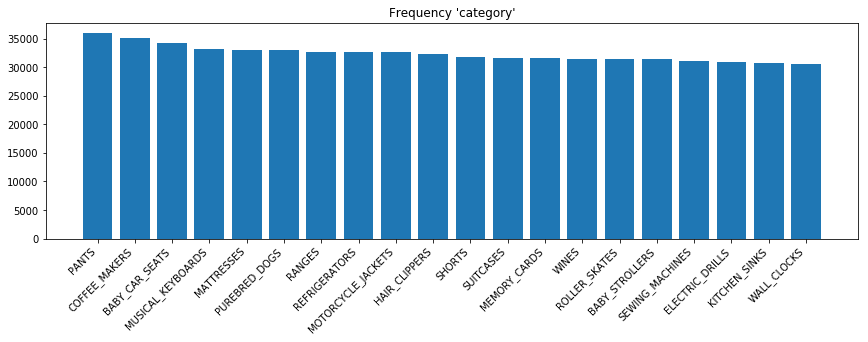

In [28]:
df_items_meli.plot.frequency('category', buckets=20)

###  Create a Dataframe

In [6]:
from pyspark.sql.types import *
from datetime import date, datetime

df = op.create.df(
    [
        ("names", "str", True), 
        ("height(ft)","int", True), 
        ("function", "str", True), 
        ("rank", "int", True), 
        ("age","int",True),
        ("weight(t)","float",True),
        ("japanese name", ArrayType(StringType()), True),
        ("last position seen", "str", True),
        ("date arrival", "str", True),
        ("last date seen", "str", True),
        ("attributes", ArrayType(FloatType()), True),
        ("DateType"),
        ("Tiemstamp"),
        ("Cybertronian", "bool", True), 
        ("NullType", "null", True),
    ],
    [
        ("Optim'us", 28, "Leader", 10, 5000000, 4.3, ["Inochi", "Convoy"], "19.442735,-99.201111", "1980/04/10",
         "2016/09/10", [8.5344, 4300.0], date(2016, 9, 10), datetime(2014, 6, 24), True,
         None),
        ("bumbl#ebéé  ", 17, "Espionage", 7, 5000000, 2.0, ["Bumble", "Goldback"], "10.642707,-71.612534", "1980/04/10",
         "2015/08/10", [5.334, 2000.0], date(2015, 8, 10), datetime(2014, 6, 24), True,
         None),
        ("ironhide&", 26, "Security", 7, 5000000, 4.0, ["Roadbuster"], "37.789563,-122.400356", "1980/04/10",
         "2014/07/10", [7.9248, 4000.0], date(2014, 6, 24), datetime(2014, 6, 24), True,
         None),
        ("Jazz", 13, "First Lieutenant", 8, 5000000, 1.80, ["Meister"], "33.670666,-117.841553", "1980/04/10",
         "2013/06/10", [3.9624, 1800.0], date(2013, 6, 24), datetime(2014, 6, 24), True, None),
        ("Megatron", None, "None", 10, 5000000, 5.70, ["Megatron"], None, "1980/04/10", "2012/05/10", [None, 5700.0],
         date(2012, 5, 10), datetime(2014, 6, 24), True, None),
        ("Metroplex_)^$", 300, "Battle Station", 8, 5000000, None, ["Metroflex"], None, "1980/04/10", "2011/04/10",
         [91.44, None], date(2011, 4, 10), datetime(2014, 6, 24), True, None),

    ], infer_schema = True).h_repartition(1)

In [7]:
df.table()

names 1 (string) nullable,height(ft) 2 (int) nullable,function 3 (string) nullable,rank 4 (int) nullable,age 5 (int) nullable,weight(t) 6 (float) nullable,japanese name 7 (array<string>) nullable,last position seen 8 (string) nullable,date arrival 9 (string) nullable,last date seen 10 (string) nullable,attributes 11 (array<float>) nullable,DateType 12 (date) nullable,Tiemstamp 13 (timestamp) nullable,Cybertronian 14 (boolean) nullable,NullType 15 (null) nullable
Optim'us,28,Leader,10,5000000,4.300000190734863,"['Inochi',⋅'Convoy']","19.442735,-99.201111",1980/04/10,2016/09/10,"[8.53439998626709,⋅4300.0]",2016-09-10,2014-06-24⋅00:00:00,True,None
bumbl#ebéé⋅⋅,17,Espionage,7,5000000,2.0,"['Bumble',⋅'Goldback']","10.642707,-71.612534",1980/04/10,2015/08/10,"[5.334000110626221,⋅2000.0]",2015-08-10,2014-06-24⋅00:00:00,True,None
ironhide&,26,Security,7,5000000,4.0,['Roadbuster'],"37.789563,-122.400356",1980/04/10,2014/07/10,"[7.924799919128418,⋅4000.0]",2014-06-24,2014-06-24⋅00:00:00,True,None
Jazz,13,First⋅Lieutenant,8,5000000,1.7999999523162842,['Meister'],"33.670666,-117.841553",1980/04/10,2013/06/10,"[3.962399959564209,⋅1800.0]",2013-06-24,2014-06-24⋅00:00:00,True,None
Megatron,None,None,10,5000000,5.699999809265137,['Megatron'],None,1980/04/10,2012/05/10,"[None,⋅5700.0]",2012-05-10,2014-06-24⋅00:00:00,True,None
Metroplex_)^$,300,Battle⋅Station,8,5000000,None,['Metroflex'],None,1980/04/10,2011/04/10,"[91.44000244140625,⋅None]",2011-04-10,2014-06-24⋅00:00:00,True,None


In [8]:
# This is a custom function
def func(value, arg):
    return "this was a number"
    
new_df = df\
    .rows.sort("rank","desc")\
    .withColumn('new_age', df.age)\
    .cols.lower(["names","function"])\
    .cols.date_transform("date arrival", "yyyy/MM/dd", "dd-MM-YYYY")\
    .cols.years_between("date arrival", "dd-MM-YYYY", output_cols = "from arrival")\
    .cols.remove_accents("names")\
    .cols.remove_special_chars("names")\
    .rows.drop(df["rank"]>8)\
    .cols.rename(str.lower)\
    .cols.trim("*")\
    .cols.unnest("japanese name", output_cols="other names")\
    .cols.unnest("last position seen",separator=",", output_cols="pos")\
    .cols.drop(["last position seen", "japanese name","date arrival", "cybertronian", "nulltype"])


In [9]:
new_df.table()

names 1 (string) nullable,height(ft) 2 (string) nullable,function 3 (string) nullable,rank 4 (string) nullable,age 5 (string) nullable,weight(t) 6 (string) nullable,last date seen 7 (string) nullable,attributes 8 (array<float>) nullable,datetype 9 (string) nullable,tiemstamp 10 (timestamp) nullable,new_age 11 (string) nullable,from arrival 12 (string) nullable,other names_0 13 (string) nullable,other names_1 14 (string) nullable,pos_0 15 (string) nullable,pos_1 16 (string) nullable
jazz,13,first⋅lieutenant,8,5000000,1.8,2013/06/10,"[3.962399959564209,⋅1800.0]",2013-06-24,2014-06-24⋅00:00:00,5000000,39.5,Meister,None,33.670666,-117.841553
metroplex,300,battle⋅station,8,5000000,None,2011/04/10,"[91.44000244140625,⋅None]",2011-04-10,2014-06-24⋅00:00:00,5000000,39.5,Metroflex,None,None,None
bumblebee,17,espionage,7,5000000,2.0,2015/08/10,"[5.334000110626221,⋅2000.0]",2015-08-10,2014-06-24⋅00:00:00,5000000,39.5,Bumble,Goldback,10.642707,-71.612534
ironhide,26,security,7,5000000,4.0,2014/07/10,"[7.924799919128418,⋅4000.0]",2014-06-24,2014-06-24⋅00:00:00,5000000,39.5,Roadbuster,None,37.789563,-122.400356


In [18]:
def func(value, args):
    return value + args[0] + args[1]

df.cols.apply("height(ft)",func,"int", [1,2]).table()

names 1 (string) nullable,height(ft) 2 (int) nullable,function 3 (string) nullable,rank 4 (int) nullable,age 5 (int) nullable,weight(t) 6 (float) nullable,japanese name 7 (array<string>) nullable,last position seen 8 (string) nullable,date arrival 9 (string) nullable,last date seen 10 (string) nullable,attributes 11 (array<float>) nullable,DateType 12 (date) nullable,Tiemstamp 13 (timestamp) nullable,Cybertronian 14 (boolean) nullable,NullType 15 (null) nullable
Optim'us,31,Leader,10,5000000,4.300000190734863,"['Inochi',⋅'Convoy']","19.442735,-99.201111",1980/04/10,2016/09/10,"[8.53439998626709,⋅4300.0]",2016-09-10,2014-06-24⋅00:00:00,True,None
bumbl#ebéé⋅⋅,20,Espionage,7,5000000,2.0,"['Bumble',⋅'Goldback']","10.642707,-71.612534",1980/04/10,2015/08/10,"[5.334000110626221,⋅2000.0]",2015-08-10,2014-06-24⋅00:00:00,True,None
ironhide&,29,Security,7,5000000,4.0,['Roadbuster'],"37.789563,-122.400356",1980/04/10,2014/07/10,"[7.924799919128418,⋅4000.0]",2014-06-24,2014-06-24⋅00:00:00,True,None
Jazz,16,First⋅Lieutenant,8,5000000,1.7999999523162842,['Meister'],"33.670666,-117.841553",1980/04/10,2013/06/10,"[3.962399959564209,⋅1800.0]",2013-06-24,2014-06-24⋅00:00:00,True,None
Megatron,None,None,10,5000000,5.699999809265137,['Megatron'],None,1980/04/10,2012/05/10,"[None,⋅5700.0]",2012-05-10,2014-06-24⋅00:00:00,True,None
Metroplex_)^$,303,Battle⋅Station,8,5000000,None,['Metroflex'],None,1980/04/10,2011/04/10,"[91.44000244140625,⋅None]",2011-04-10,2014-06-24⋅00:00:00,True,None


In [17]:
op.output("html")
op.output("ascii")

## Data profiling

##### read Meteorite Landings CSV

In [19]:
df = op.load.csv("https://raw.githubusercontent.com/ironmussa/Optimus/master/examples/data/Meteorite_Landings.csv").h_repartition()

Including 'nan' as Null in processing 'name'
Including 'nan' as Null in processing 'nametype'
Including 'nan' as Null in processing 'recclass'
Including 'nan' as Null in processing 'fall'
Including 'nan' as Null in processing 'year'
Including 'nan' as Null in processing 'GeoLocation'


Number of columns,10
Number of rows,45716
Total Missing (%),0.49%
Total size in memory,-1 Bytes
String,0
Numeric,1
Date,0
Bool,0
Array,0
Not available,0
Unique,12497

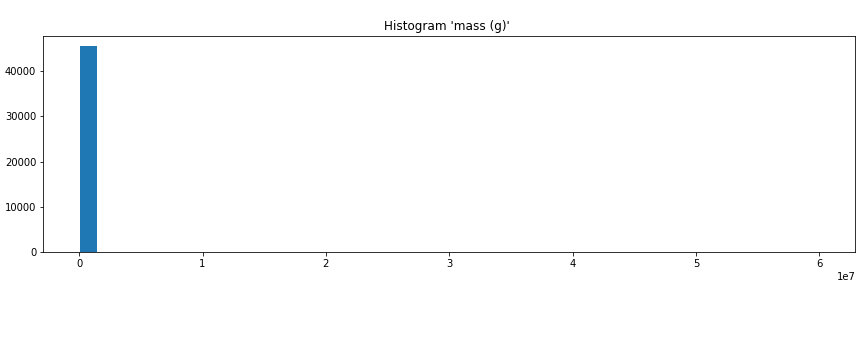
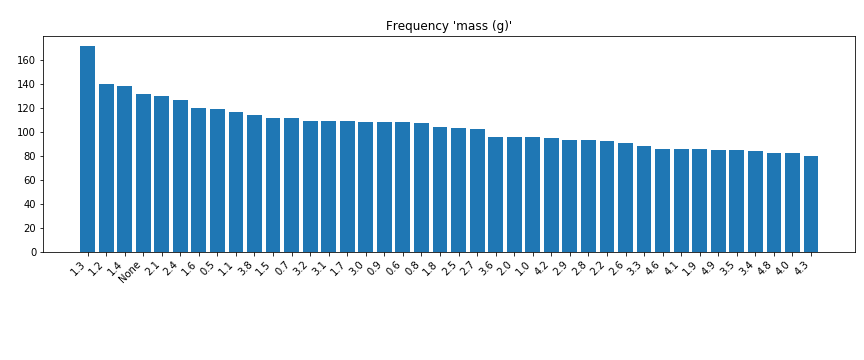

In [20]:
op.profiler.run(df, "mass (g)", infer=False)

Including 'nan' as Null in processing 'name'
Including 'nan' as Null in processing 'nametype'
Including 'nan' as Null in processing 'recclass'
Including 'nan' as Null in processing 'fall'
Including 'nan' as Null in processing 'year'
Including 'nan' as Null in processing 'GeoLocation'


Number of columns,10
Number of rows,45716
Total Missing (%),0.49%
Total size in memory,-1 Bytes
String,0
Numeric,0
Date,1
Bool,0
Array,0
Not available,0
Unique,265

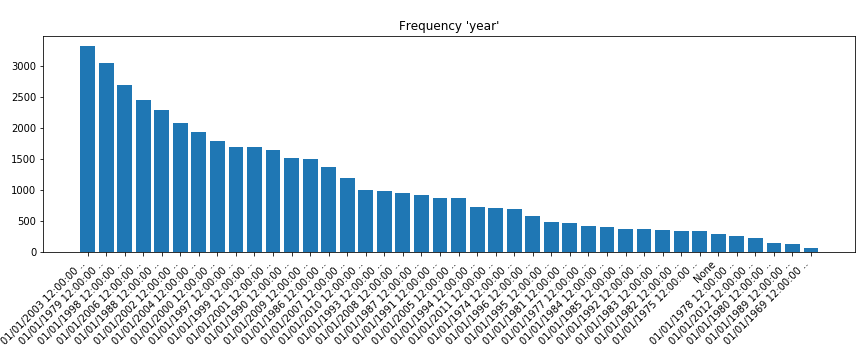
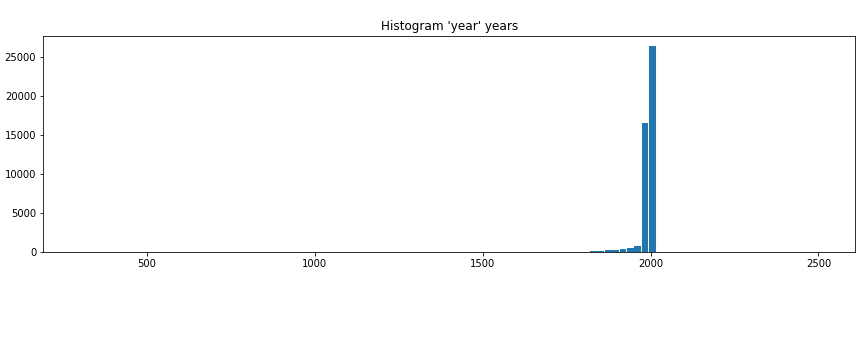
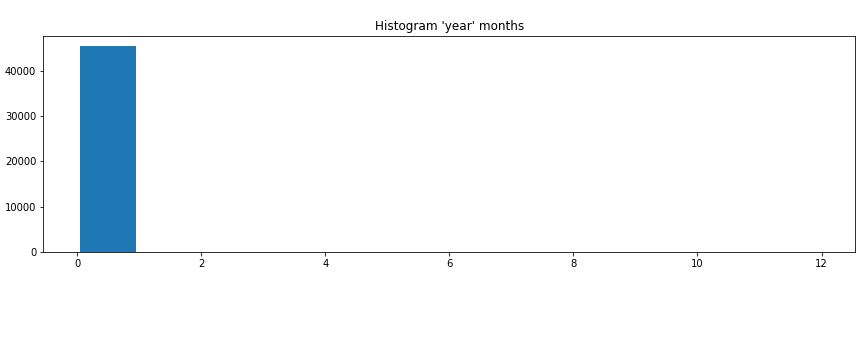
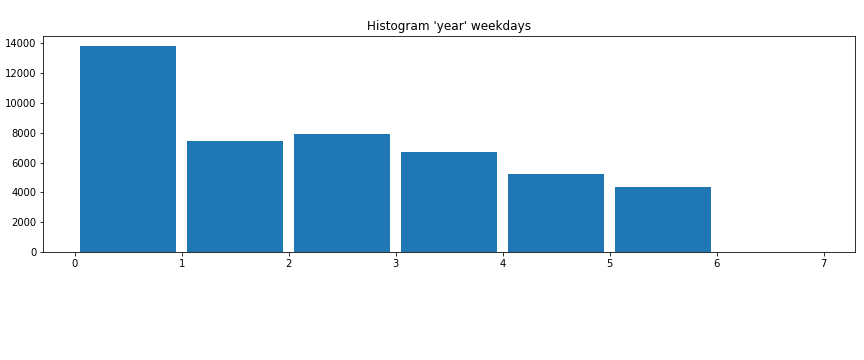
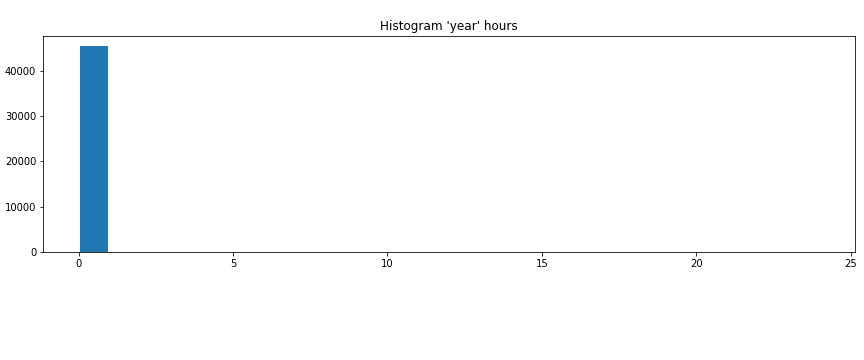
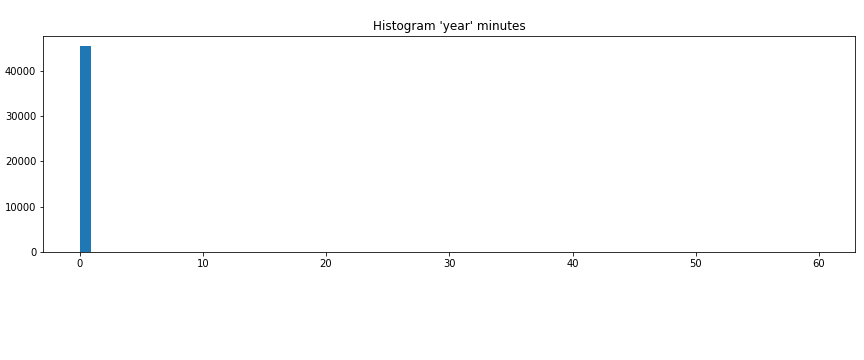

In [21]:
op.profiler.run(df, "year", infer=True)